# *From Corpus to Classroom: Interactive Access to Children’s Song Repertoires on the MUSCO Platform*
## Authors: Vanessa Nina Borsan, Jure Juvan, Matija Marolt, Matevž Pesek, Leon Stefanija
### Presented as a poster @ ICCCM ’25, 8-10 October 2025, Aalborg University, Aalborg, DENMARK

------


## The following notebook includes usage examples of scripts for:
1. Data Preprocessing
2. Data Plotting
3. Evaluation, and
4. Pattern Matching.

-----

# LOAD DATA

In [1]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd() / "src"))

p = Path.cwd()
while p != p.parent and not (p / "src").exists():
    p = p.parent
sys.path.insert(0, str(p / "src"))

from educationalfilters import prepare_df
from educationalfilters import save_load
from educationalfilters.pipeline import apply_all_filters
import pandas as pd
import importlib
from educationalfilters import filter_label_utils as flu, filter_df
importlib.reload(flu)
importlib.reload(filter_df)


<module 'educationalfilters.filter_df' from '/Users/vanessaborsan/FF_Identifikacije/MUSCO/src/educationalfilters/filter_df.py'>

In [2]:
# Resolve paths relative to repo root
REPO_ROOT = Path(p)                          # from previous cell
RAW_DIR    = REPO_ROOT / "data" / "raw"
PROC_DIR   = REPO_ROOT / "data" / "processed"

CIC_JSON_DIR = str((RAW_DIR / "ciciban_jsons").resolve())
SLP_CSV      = str((RAW_DIR / "slp_df.csv").resolve())
SLP_SCORES   = str((REPO_ROOT / "scores/slp").resolve())    # folder with .mxl files
RHY_MAP_FILE = "rhythm_mapping.pickle"                      # lives in data/processed/ via save_load

print(CIC_JSON_DIR)
print(SLP_CSV)
print(SLP_SCORES)

/Users/vanessaborsan/FF_Identifikacije/MUSCO/data/raw/ciciban_jsons
/Users/vanessaborsan/FF_Identifikacije/MUSCO/data/raw/slp_df.csv
/Users/vanessaborsan/FF_Identifikacije/MUSCO/scores/slp


In [3]:
# Build Ciciban DF from JSONs (notes-only rhythm, pause_count from JSON rhythm vs melody length)
c_df = prepare_df.convert_jsons_to_df(CIC_JSON_DIR)

# Upgrade to ABC using canonical map (creates/extends data/processed/rhythm_mapping.pickle)
c_df, rhythm_mapping = prepare_df.df_upgrade(c_df, save_file_path=RHY_MAP_FILE)

print(f"{len(c_df)} Ciciban rows")
display(c_df.head(3))

123 Ciciban rows


,metadata_filename,corpus,metadata_composer,metadata_lyricist,metadata_title,key,time_signature,ambitus_min,ambitus_max,ambitus_semitones,...,melodic_string,melodic_string_absolute,melodic_string_abc,melodic_string_relative,rhythm_string,rhythmic_measures,melodic_measures,has_pauses,pause_count,rhythm_string_abc
0,MLADI PIONIRJI,Ciciban,Marjan Kozina,None,MLADI PIONIRJI,G,2/4,D4,C5,10,...,U U U D U D U D D D U U U D D D S S U D D U U ...,62 64 66 67 62 69 62 71 67 66 64 66 67 69 67 6...,D4 E4 F#4 G4 D4 A4 D4 B4 G4 F#4 E4 F#4 G4 A4 G...,2 2 1 -5 7 -7 9 -4 -1 -2 2 1 2 -2 -3 -2 0 0 10...,"[0.5, 0.75, 0.25, 1.0, 1.0, 1.0, 1.0, 2.0, 1.5...","[0, 3, 5, 7, 8, 10, 12, 16, 17, 19, 21, 25, 26...","[0, 3, 5, 7, 8, 10, 12, 16, 17, 19, 21, 25, 26...",False,0,akhddddelalakhaaeddlakhaaelalakhaaea
1,Kako petelinček poje,Ciciban,Ciril Pregelj,None,Kako petelinček poje,G,4/4,G2,B6,52,...,S U D U S S S U D U U D D U U D D D S S S S S ...,67 67 69 62 67 67 67 67 69 62 71 74 72 69 71 7...,G4 G4 A4 D4 G4 G4 G4 G4 A4 D4 B4 D5 C5 A4 B4 D...,0 2 -7 5 0 0 0 2 -7 9 3 -2 -3 2 3 -2 -3 -7 0 0...,"[4.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, ...","[0, 1, 5, 11, 15, 19, 27, 35, 39, 43, 48, 49, 50]","[0, 4, 10, 14, 18, 26, 34, 38, 42]",True,5,nddddaaaadddkhedkheaaaaaaaaaaaaaaaadkhedkhedkh
2,ČIRIBIRI - NADALJEVANKA,Ciciban,M. Voglar,None,ČIRIBIRI - NADALJEVANKA,D,5/4,D4,B4,9,...,U D D U D D D D U U U D D D S U S D S U S D D D,69 71 69 66 69 67 66 64 62 64 66 69 67 66 64 6...,A4 B4 A4 F#4 A4 G4 F#4 E4 D4 E4 F#4 A4 G4 F#4 ...,2 -2 -3 3 -2 -1 -2 -2 2 2 3 -2 -1 -2 0 5 0 -3 ...,"[0.5, 0.5, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[0, 4, 8, 12, 16, 20, 24, 25]","[0, 4, 8, 12, 16, 20, 24]",True,1,aaddaaaaaaddaaaaaaaaddaam


# PREPARE DFs

In [4]:
# Load SLP CSV + parse .mxl rhythms/time sigs; apply canonical ABC mapping
slp_df = prepare_df.prepare_slp(SLP_CSV, SLP_SCORES, RHY_MAP_FILE)

# (Optional) harmonize a couple of fields if needed by downstream code
if "min_pitch" in slp_df.columns and "max_pitch" in slp_df.columns:
    slp_df["ambitus_min"] = slp_df["ambitus_min"].fillna(slp_df["min_pitch"])
    slp_df["ambitus_max"] = slp_df["ambitus_max"].fillna(slp_df["max_pitch"])
slp_df["time_signature"] = slp_df["time_signature"].astype(str).str.extract(r"(\d+/\d+)", expand=False)

print(f"{len(slp_df)} SLP rows")
display(slp_df.head(3))

✅ Updating: 237.3 → /Users/vanessaborsan/FF_Identifikacije/MUSCO/scores/slp/237-3.mxl
🎵 Extracted Rhythm (237.3): [0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0]
🕒 Extracted Time Signatures: ['5/8', '6/8', '3/4']
🎼 Converted Rhythm ABC: adadaaaadadaaaaaaadadaaaaaaadadaaaaaaad
✅ Updating: 237.4 → /Users/vanessaborsan/FF_Identifikacije/MUSCO/scores/slp/237-4.mxl
🎵 Extracted Rhythm (237.4): [0.5, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 2.0, 0.5, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 2.0]
🕒 Extracted Time Signatures: ['3/4']
🎼 Converted Rhythm ABC: aladladladealadladlade
✅ Updating: 237.5 → /Users/vanessaborsan/FF_Identifikacije/MUSCO/scores/slp/237-5.mxl
🎵 Extracted Rhythm (237.5): [0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0]
🕒 Extracted

,metadata_filename,ambitus_min,ambitus_max,ambitus_semitones,time_signature,melodic_string_nice,interval_mean,interval_median,melodic_string_relative,ambitus_interval,rhythm_string,rhythm_string_abc,rhythm_length,pause_count,has_pauses,melodic_string_abc,corpus
0,237.3,D4,C5,10,5/8,D4 B4 B4 A4 C5 B4 A4 G4 A4 D4 A4 A4 G4 A4 B4 C...,m3,M2,9 0 -2 3 -1 -2 -2 2 -7 7 0 -2 2 2 1 -8 2 1 -5 ...,SEVENTH,"[0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, ...",adadaaaadadaaaaaaadadaaaaaaadadaaaaaaad,39,0,NO,,SLP
1,237.4,F#4,G5,13,3/4,D5 E5 F#5 G5 E5 E5 G5 E5 E5 D5 C5 A4 E5 D5 B4 ...,M2,M2,2 2 1 -3 0 3 -3 0 -2 -2 -3 7 -2 -3 0 1 -6 0 1,ABOVE OCTAVE,"[0.5, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, ...",aladladladealadladlade,22,3,YES,,SLP
2,237.5,G4,A5,14,3/8,G4 D5 D5 B4 G4 E5 E5 E5 D5 E5 G5 G5 F#5 G5 A5 ...,M2,M2,7 0 -3 -4 9 0 0 -2 2 3 0 -1 1 2 -2 0 -3 -2 0 2...,ABOVE OCTAVE,"[0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, ...",adadaaaadadaaaaaaaaadadaaaad,28,2,YES,,SLP


## RHYTHM MAPPING REFERENCE

In [5]:
import pprint
from educationalfilters import save_load

# Load the canonical rhythm mapping
rhythm_mapping = save_load.load_pickle("rhythm_mapping.pickle")

print("🎼 Current Rhythm Mapping (duration → letter) [FIXED: a (0.5), d (1.0), e (2.0); AUTOMATICALLY GENERATED: the rest]:")
pprint.pprint(dict(sorted(rhythm_mapping.items())))

🎼 Current Rhythm Mapping (duration → letter) [FIXED: a (0.5), d (1.0), e (2.0); AUTOMATICALLY GENERATED: the rest]:
{0.0: 'f',
 0.125: 'g',
 0.16666666666666666: 'q',
 0.25: 'h',
 0.3333333333333333: 'i',
 0.375: 'j',
 0.5: 'a',
 0.6666666666666666: 'p',
 0.75: 'k',
 0.8: 'r',
 1.0: 'd',
 1.5: 'l',
 1.6: 's',
 2.0: 'e',
 3.0: 'm',
 4.0: 'n',
 5.0: 'o'}


## VRF & IF 
- Condition 1: Range should extend from min A3 to max C5
- Condition 2: Interval jumps should ideally be in seconds (we add a minor and major third, because none only include seconds), but no more than P5

In [6]:
pre_min_range='C4'
pre_max_range='A4'
pre_plus_min_range='A3'
pre_plus_max_range='C5'

In [7]:
pre_min_range      = 'C4'
pre_max_range      = 'A4'
pre_plus_min_range = 'A3'
pre_plus_max_range = 'C5'

# Apply to Ciciban
ciciban_df = filter_df.preschool_filter(
    c_df,
    pre_plus_min_pitch=pre_plus_min_range,
    pre_plus_max_pitch=pre_plus_max_range,
    pre_min_pitch=pre_min_range,
    pre_max_pitch=pre_max_range,
    rhythm_mapping=rhythm_mapping,  # accepted but not required by RF
)

# Apply to SLP
slp_df_f = filter_df.preschool_filter(
    slp_df,
    pre_plus_min_pitch=pre_plus_min_range,
    pre_plus_max_pitch=pre_plus_max_range,
    pre_min_pitch=pre_min_range,
    pre_max_pitch=pre_max_range,
    rhythm_mapping=rhythm_mapping,
)

In [8]:
slp_df_f

,metadata_filename,ambitus_min,ambitus_max,ambitus_semitones,time_signature,melodic_string_nice,interval_mean,interval_median,melodic_string_relative,ambitus_interval,...,melodic_string_abc,corpus,VRF_label,IF_label,IF1_reason,IF2_reason,RF_label,VRF_BOTH,IF_BOTH,RF_BOTH
0,237.3,D4,C5,10,5/8,D4 B4 B4 A4 C5 B4 A4 G4 A4 D4 A4 A4 G4 A4 B4 C...,m3,M2,9 0 -2 3 -1 -2 -2 2 -7 7 0 -2 2 2 1 -8 2 1 -5 ...,SEVENTH,...,,SLP,VRF2,X,fails IF1,fails IF2,RF4,True,False,True
1,237.4,F#4,G5,13,3/4,D5 E5 F#5 G5 E5 E5 G5 E5 E5 D5 C5 A4 E5 D5 B4 ...,M2,M2,2 2 1 -3 0 3 -3 0 -2 -2 -3 7 -2 -3 0 1 -6 0 1,ABOVE OCTAVE,...,,SLP,X,X,fails IF1,fails IF2,RF4,False,False,True
2,237.5,G4,A5,14,3/8,G4 D5 D5 B4 G4 E5 E5 E5 D5 E5 G5 G5 F#5 G5 A5 ...,M2,M2,7 0 -3 -4 9 0 0 -2 2 3 0 -1 1 2 -2 0 -3 -2 0 2...,ABOVE OCTAVE,...,,SLP,X,X,fails IF1,fails IF2,RF4,False,False,True
3,239.1.A,G4,E5,9,6/8,D5 B4 D5 E5 D5 D5 C5 B4 D5 B4 D5 E5 D5 D5 C5 B...,M2,M2,-3 3 2 -2 0 -2 -1 3 -3 3 2 -2 0 -2 -1 1 -3 -2 ...,SIXTH,...,,SLP,X,IF2,fails IF1,OK,RF4,False,True,True
4,239.5.A,F#4,G5,13,3/8,D5 B4 D5 G5 E5 D5 C5 D5 E5 D5 D5 E5 D5 C5 B4 B...,m3,M2,-3 3 5 -3 -2 -2 2 2 -2 0 2 -2 -2 -1 0 3 -7 4 3...,ABOVE OCTAVE,...,,SLP,X,X,fails IF1,fails IF2,RF4,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397,287.75,D4,C5,10,2/4,D4 E4 F#4 G4 E4 D4 G4 B4 C5 B4 G4 D4 B4 C5 B4 ...,M2,M2,2 2 1 -3 -2 5 4 1 -1 -4 -5 9 1 -1 0 -2 0 -2,SEVENTH,...,,SLP,VRF2,X,fails IF1,fails IF2,RF4,True,False,True
398,287.76,B3,G4,8,3/4,D4 D4 D4 D4 D4 E4 D4 B3 B3 C4 D4 D4 E4 G4 F#4 ...,M2,M2,0 0 0 0 2 -2 -3 0 1 2 0 2 3 -1 1 0 -1 1 -1 -2 ...,SIXTH,...,,SLP,VRF2,X,fails IF1,fails IF2,RF4,True,False,True
399,287.77,F#4,E5,10,4/4,G4 A4 B4 A4 G4 G4 A4 B4 A4 G4 G4 A4 B4 E5 E5 E...,M2,M2,2 2 -2 -2 0 2 2 -2 -2 0 2 2 5 0 0 -2 -2 -1 -2 ...,SEVENTH,...,,SLP,X,X,fails IF1,fails IF2,RF3,False,False,True
400,287.78,G4,E5,9,3/4,B4 B4 B4 A4 B4 C5 B4 G4 G4 A4 B4 B4 C5 E5 D5 E...,M2,M2,0 0 -2 2 1 -1 -4 0 2 2 0 1 4 -2 2 0 -2 2 -2 -2...,SIXTH,...,,SLP,X,IF2,fails IF1,OK,RF4,False,True,True


## CONVERT RHYTHMS AND MELODIC INTERVALS

In [9]:
dfs=[slp_df_f, ciciban_df]
labels=['SLP', 'Ciciban']

In [10]:
from educationalfilters import dataset_conversion as dc, rfilters

# Adapter so the new rfilters works with the old function signature
def _rf_adapter(df, rhythm_mapping, label):
    df2 = df.copy()
    df2['corpus'] = label
    return rfilters.compute_rhythm_labels(df2)  # -> (df_out, counts)

KEEP_COLS = [
    "metadata_filename", "metadata_title", "corpus",
    "melodic_string", "melodic_string_absolute", "melodic_string_abc",
    "melodic_string_relative", "melodic_intervals",
    "rhythm_string", "rhythm_string_abc", "time_signature",
    "has_pauses", "pause_count",
    "ambitus_min", "ambitus_max", "ambitus_semitones", "ambitus_interval",
    "VRF_label", "IF_label", "RF_label",
    "VRF_BOTH", "IF_BOTH", "RF_BOTH",  # include only if you compute these earlier
]

merged_df, all_counts = dc.process_and_merge_dfs(
    dfs, labels, rhythm_mapping, filter_function=_rf_adapter, keep_cols=KEEP_COLS
)
merged_df = dc.prepare_melodic_intervals(merged_df)

print(merged_df.shape)
merged_df.head(3)

(525, 23)


,metadata_filename,metadata_title,corpus,melodic_string,melodic_string_absolute,melodic_string_abc,melodic_string_relative,melodic_intervals,rhythm_string,rhythm_string_abc,...,ambitus_min,ambitus_max,ambitus_semitones,ambitus_interval,VRF_label,IF_label,RF_label,VRF_BOTH,IF_BOTH,RF_BOTH
0,237.3,NaN,SLP,NaN,NaN,,9 0 -2 3 -1 -2 -2 2 -7 7 0 -2 2 2 1 -8 2 1 -5 ...,jacdbccchhacccbicbfbabccbbccchhaccdaicb,"[0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, ...",adadaaaadadaaaaaaadadaaaaaaadadaaaaaaad,...,D4,C5,10,SEVENTH,VRF2,X,RF4,True,False,True
1,237.4,NaN,SLP,NaN,NaN,,2 2 1 -3 0 3 -3 0 -2 -2 -3 7 -2 -3 0 1 -6 0 1,ccbdaddaccdhcdabgab,"[0.5, 1.5, 0.5, 1.0, 1.5, 0.5, 1.0, 1.5, 0.5, ...",aladladladealadladlade,...,F#4,G5,13,ABOVE OCTAVE,X,X,RF4,False,False,True
2,237.5,NaN,SLP,NaN,NaN,,7 0 -3 -4 9 0 0 -2 2 3 0 -1 1 2 -2 0 -3 -2 0 2...,hadejaaccdabbccadcacecdbbcc,"[0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 1.0, ...",adadaaaadadaaaaaaaaadadaaaad,...,G4,A5,14,ABOVE OCTAVE,X,X,RF4,False,False,True


In [11]:
# These columns are not being used in this case study, so they were not considered and dropped from the df.
drop_cols = ["metadata_title", "melodic_string", "melodic_string_absolute"]
drop_cols = [c for c in drop_cols if c in merged_df.columns]  

merged_df = merged_df.drop(columns=drop_cols)

## DATA CLEAN UP

In [ ]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd() / "src"))

from educationalfilters import filter_df
from educationalfilters import dataset_conversion as dc

In [17]:
summary_clean = filter_df.prepare_all_filters_clean(merged_df)  # fixed row order for plotting
display(summary_clean)

,Ciciban,SLP
VRF1,26.016260,0.248756
IF1,4.065041,6.467662
VRF2,76.422764,24.626866
IF2,67.479675,49.253731
VRF1 + IF1,0.813008,0.000000
VRF2+IF2,32.520325,7.462687
ANY (VRF+IF),60.975610,8.457711
RF1,38.211382,8.208955
RF2,40.650407,9.452736
RF3,48.780488,43.532338


## PLOT

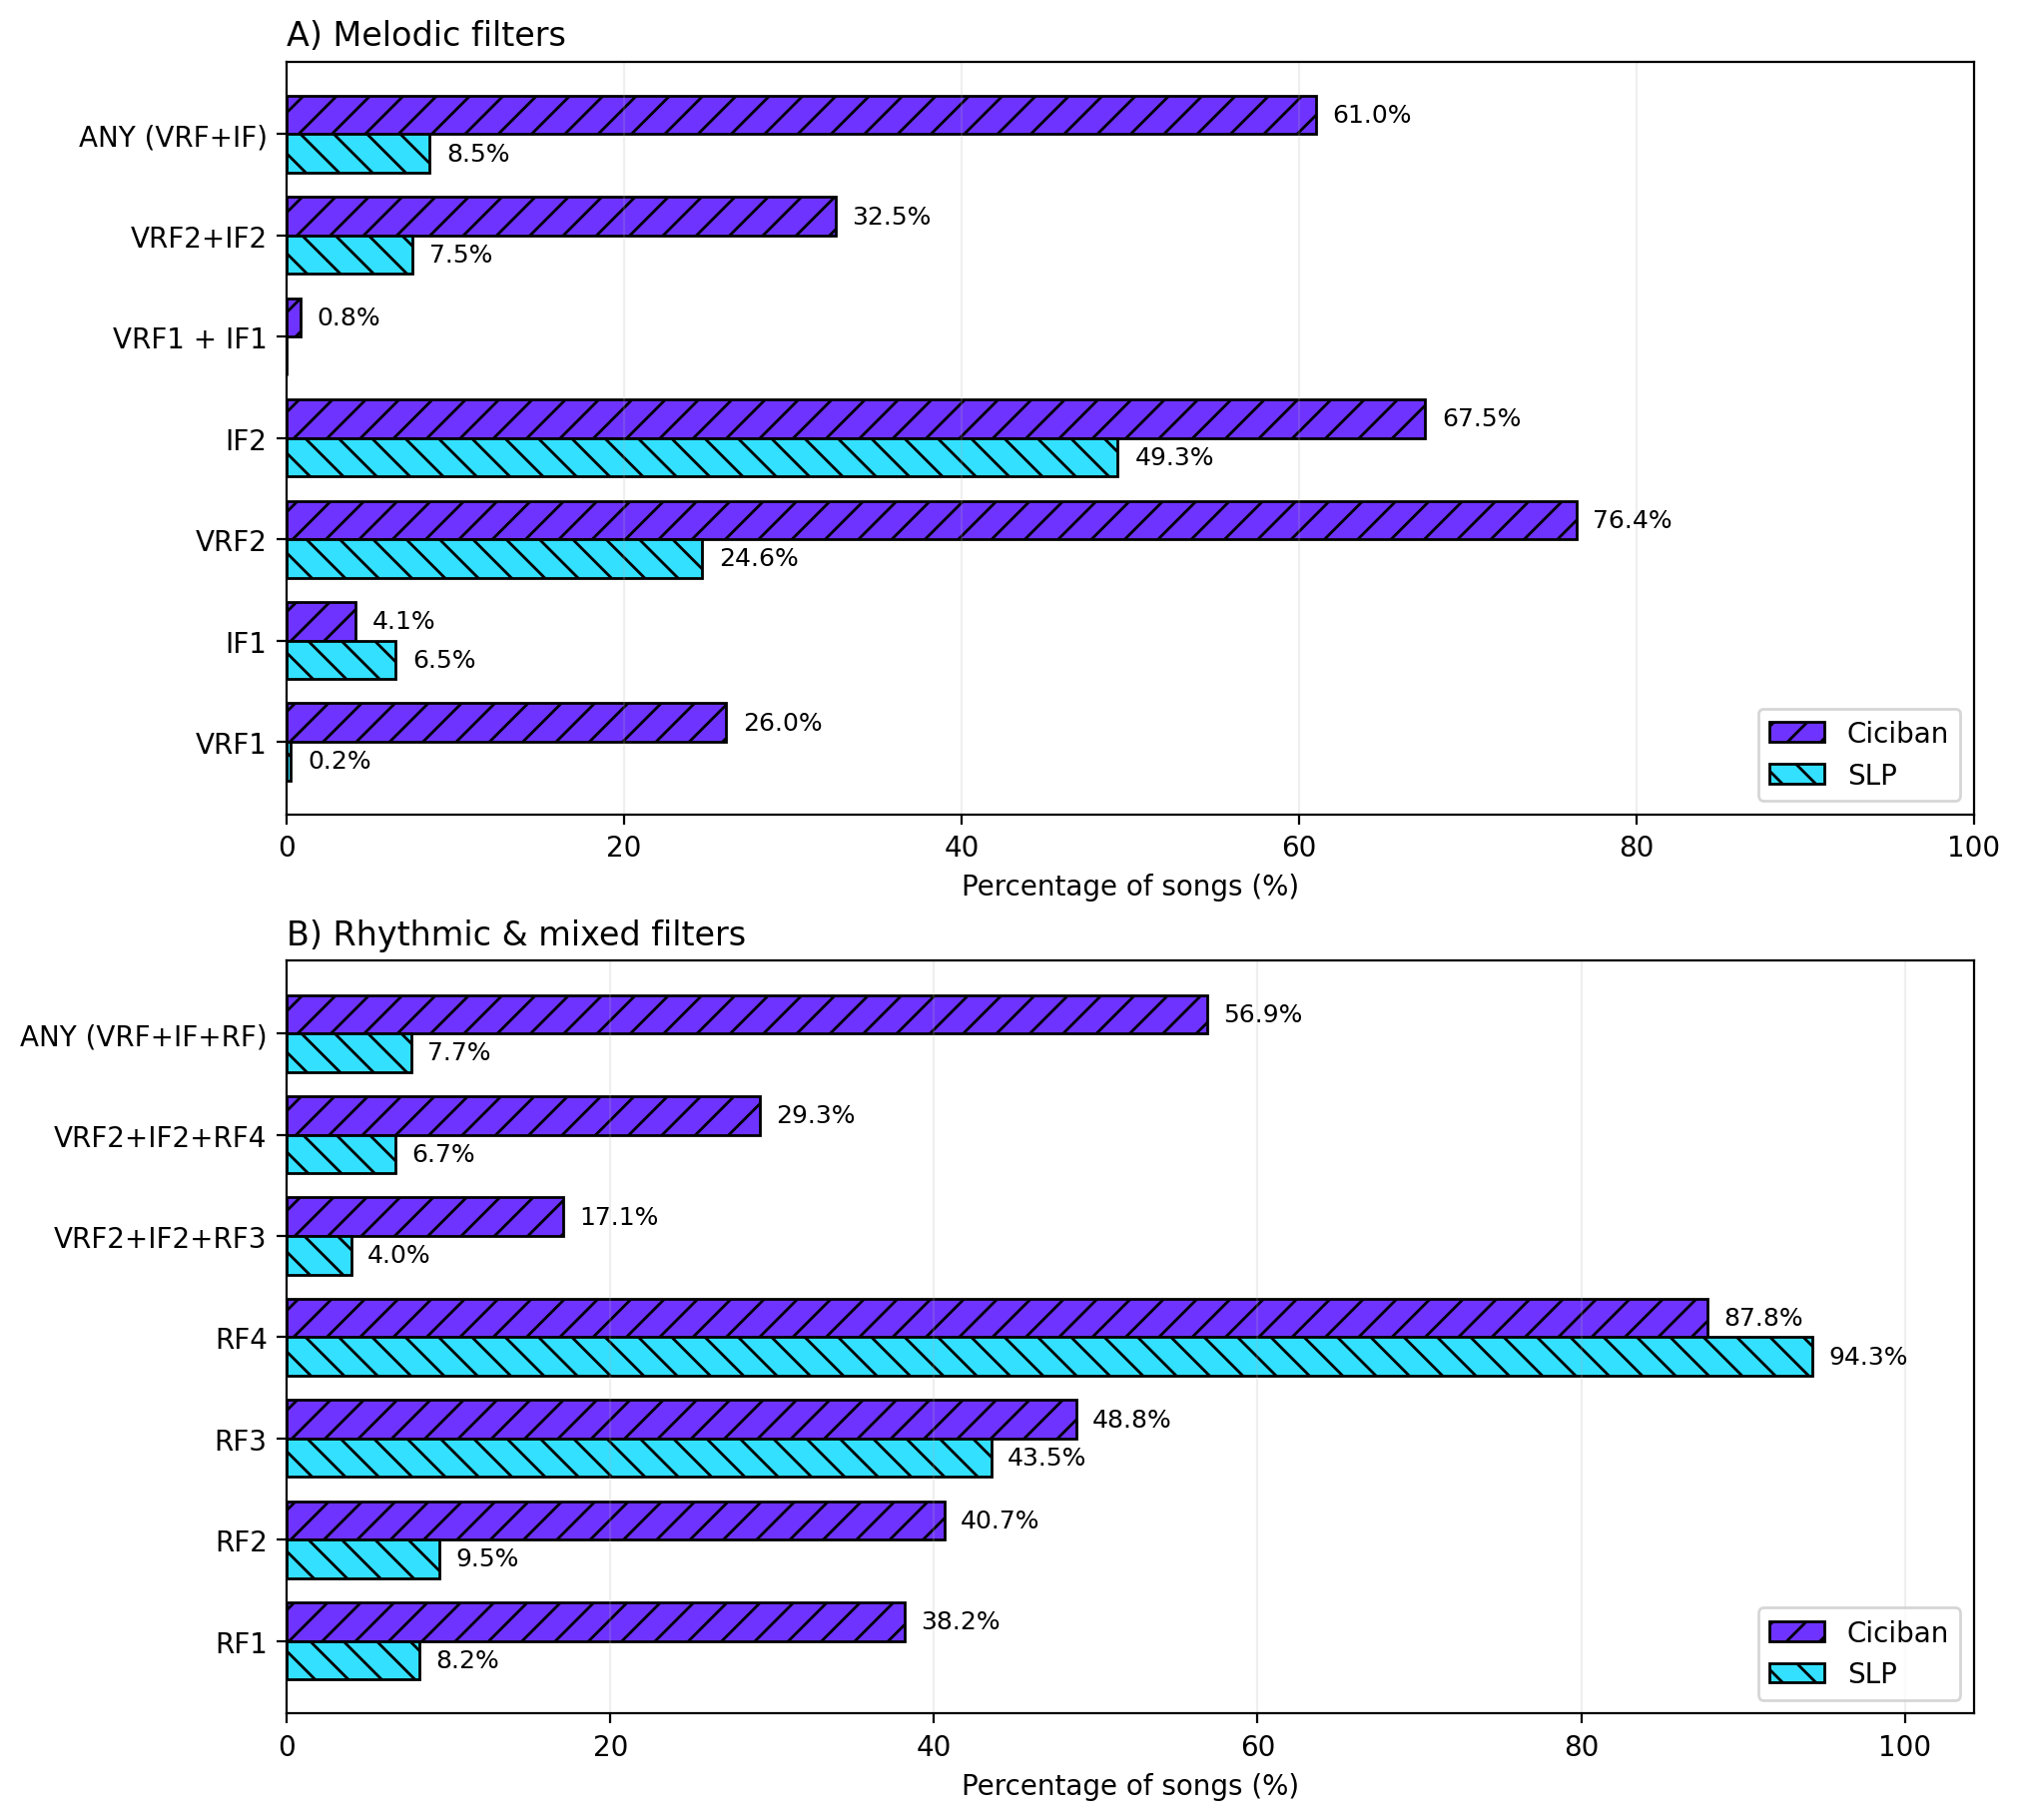

In [18]:
# --- plotting helper (drop-in replacement for your old plot.plot_filters) ---
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_filters(summary: pd.DataFrame, COLORS, HATCHES, group1, group2, save_path=None):
    """
    summary: DataFrame with rows in the order you want to display and two columns: 'Ciciban' and 'SLP'
    COLORS:  list of 2 colors [Ciciban, SLP]
    HATCHES: list of 2 hatches [Ciciban, SLP]
    group1:  list of row labels for the TOP panel (melodic)
    group2:  list of row labels for the BOTTOM panel (rhythm + mixed)
    save_path: optional path to save PNG
    """
    # Ensure row order exists in summary (reindex safely)
    top  = summary.reindex(group1)
    bottom = summary.reindex(group2)

    # Figure & axes
    fig, axes = plt.subplots(2, 1, figsize=(10, 9), constrained_layout=True)

    def _barpanel(ax, block, title):
        # indices
        y_pos = np.arange(len(block))
        height = 0.38

        # fetch values, default to 0 if NaN
        c1 = block.get('Ciciban', pd.Series([0]*len(block), index=block.index)).fillna(0).values
        c2 = block.get('SLP', pd.Series([0]*len(block), index=block.index)).fillna(0).values

        # bars (side-by-side for each row)
        ax.barh(y_pos + height/2, c1, height=height, color=COLORS[0], hatch=HATCHES[0], edgecolor='black', label='Ciciban')
        ax.barh(y_pos - height/2, c2, height=height, color=COLORS[1], hatch=HATCHES[1], edgecolor='black', label='SLP')

        # labels
        for i, (v1, v2) in enumerate(zip(c1, c2)):
            if v1 > 0:
                ax.text(v1 + 1, i + height/2, f"{v1:.1f}%", va='center', fontsize=9)
            if v2 > 0:
                ax.text(v2 + 1, i - height/2, f"{v2:.1f}%", va='center', fontsize=9)

        ax.set_yticks(y_pos)
        ax.set_yticklabels(block.index)
        ax.set_xlim(0, max(100, np.nanmax([c1, c2]) + 10))
        ax.set_xlabel("Percentage of songs (%)")
        ax.set_title(title, loc='left', fontsize=12, pad=6)
        ax.grid(axis='x', alpha=0.2)
        ax.legend(loc='lower right')

    _barpanel(axes[0], top,    "A) Melodic filters")
    _barpanel(axes[1], bottom, "B) Rhythmic & mixed filters")

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# --- use it on your prepared summaries ---
COLORS  = ['#6e33ff', '#33e0ff']  # Ciciban, SLP
HATCHES = ['//', '\\\\']

group1 = ["VRF1", "IF1", "VRF2", "IF2", "VRF1 + IF1", "VRF2+IF2", "ANY (VRF+IF)"]
group2 = ["RF1", "RF2", "RF3", "RF4", "VRF2+IF2+RF3", "VRF2+IF2+RF4", "ANY (VRF+IF+RF)"]

# summary_clean should be what you got from filter_df.prepare_all_filters_clean(df)
plot_filters(summary_clean, COLORS, HATCHES, group1, group2, save_path="exports/filters_summary.png")

# (Optional) also export the table the same way you used to
os.makedirs("exports", exist_ok=True)
summary_clean.to_csv("exports/filters_summary_clean.csv")

# EVALUATION

We only provide the descriptor part of evaluation, as 1. the melodic sequence evaluation was conducted in [redacted], and 2. due to some difficulties some less experienced users may encounter while installing all required packages to process melodic/rhythmic sequences.

## DATA PREPARATION

In [20]:
ciciban_df = df[df['corpus'] == 'Ciciban']
slp_df = df[df['corpus'] == 'SLP']

NameError: name 'df' is not defined

In [ ]:
selected_categories = [
    'ambitus_min',
    'ambitus_max',
    'ambitus_semitones',
    'ambitus_interval',
    'time_signature',
    'range_check',
    'interval_jumps_check',
    'has_pauses',
    'corpus',
    'pause_count',
    'rhythm_check'
]

In [ ]:
descriptors_ciciban, melody_ref_ciciban, rhythm_ref_ciciban, sa_ciciban_mel, bv_ciciban_mel, sa_ciciban_rhythm, bv_ciciban_rhythm = dataset_conversion.dataset_conversion(
    ciciban_df,
    selected_categories,
    descriptor_filename='df_ciciban.pickle', 
    sa_bv_filenames=['sa_ciciban_mel', 'bv_ciciban_mel', 'sa_ciciban_rhythm', 'bv_ciciban_rhythm']
)

descriptors_slp, melody_ref_slp, rhythm_ref_slp, sa_slp_mel, bv_slp_mel, sa_slp_rhythm, bv_slp_rhythm = dataset_conversion.dataset_conversion(
    slp_df,
    selected_categories,
    descriptor_filename='df_slp.pickle', 
    sa_bv_filenames=['sa_slp_mel', 'bv_slp_mel', 'sa_slp_rhythm', 'bv_slp_rhythm']
)

NameError: name 'dataset_conversion' is not defined

In [ ]:
slp_pickle='df_slp.pickle'
ciciban_pickle='df_ciciban.pickle'
ciciban_length=len(ciciban_df)
total_songs=len(df)
# rhythm_mapping

In [ ]:
ciciban_list = [ciciban_pickle, sa_ciciban_mel, bv_ciciban_mel, melody_ref_ciciban, rhythm_ref_ciciban, sa_ciciban_rhythm, bv_ciciban_rhythm, len(ciciban_df)]
slp_list = [slp_pickle, sa_slp_mel, bv_slp_mel, melody_ref_slp, rhythm_ref_slp, sa_slp_rhythm, bv_slp_rhythm, len(slp_df)]

## EVALUATION: DESCRIPTORS

In [ ]:
QUERIES = [
    # MELODY
        [
        ('range_check', ['PRE']),
        ],
        #
        [
        ('range_check', ['PRE']),
        ('interval_jumps_check', ['PRE']),
        ],
        #
        [
        ('range_check', ['PRE', 'PRE_PLUS']),
        ('interval_jumps_check', ['PRE', 'PRE_PLUS']),
        ],
        
    #+RHYTHM
        [
        ('range_check', ['PRE', 'PRE_PLUS']),
        ('rhythm_check', ['RF1', 'RF2', 'RF3','RF4']),
        ],
        #
        [
        ('range_check', ['PRE', 'PRE_PLUS']),
        ('interval_jumps_check', ['PRE', 'PRE_PLUS']),
        ('rhythm_check', ['RF1', 'RF2', 'RF3','RF4']),
        ],
        #
        [
        ('range_check', 'PRE'), 
        ('interval_jumps_check', 'PRE'),
        ],
        #
        [
        ('range_check', 'PRE'), 
        ('interval_jumps_check', ['PRE','PRE_PLUS']),
        ],
        
    #AMBITUS
        #  (5th, 6th)
        [
        ('range_check', ['PRE', 'PRE_PLUS']),
        ('interval_jumps_check', ['PRE', 'PRE_PLUS']),
        ('ambitus_interval', ['FIFTH', 'SIXTH'])],
        # (5th, 6th)
        [
        ('range_check', ['PRE', 'PRE_PLUS']),
        ('interval_jumps_check', ['PRE', 'PRE_PLUS']),
        ('ambitus_interval', ['FIFTH', 'SIXTH']),
        ('rhythm_check', ['RF1', 'RF2', 'RF3','RF4'])
        ],
        # (octave+)
        [
        ('ambitus_interval', ['ABOVE EIGHTH']),
        ],
        
]

In [ ]:
pd.set_option('display.max_colwidth', None)
evaluation_descriptors.evaluate_descriptors_only(QUERIES, ciciban_list, slp_list)

------------

# EXAMPLES OF INDIVIDUAL PATTERN MATCHING ALGORITHMS

The complete explanation of these algorithms along with examples can be found in [redacted, redacted, redacted].

## DATA PREPARATION

In [ ]:
selected_categories = [
    #'metadata_filename',
    'ambitus_min',
    'ambitus_max',
    'ambitus_semitones',
    'time_signature',
    'ambitus_interval',
    #'interval_mean',
   # 'interval_median',
    #'melodic_string_relative',
    'range_check',
    'rhythm_check',
    'interval_jumps_check',
    'has_pauses',
    'corpus',
    'pause_count'
]

In [ ]:
descriptors, melody_ref, rhythm_ref, s_a_mel, b_v_mel, s_a_rhythm, b_v_rhythm = dataset_conversion.dataset_conversion(
    df,
    selected_categories,
    descriptor_filename='descriptor_dict.pickle',
    sa_bv_filenames=['sa_mel', 'bv_mel', 'sa_rhythm', 'bv_rhythm']
)

## DESCRIPTOR SET MATCHING

In [ ]:
# Example usage:

descriptor_filepath='descriptor_dict.pickle'
target_keys = [
                ('corpus', 'Ciciban'),
                ('range_check', ['PRE', 'PRE_PLUS']), 
                ('interval_jumps_check', ['PRE', 'PRE_PLUS']), 
                #('ambitus_interval', ['ABOVE EIGHTH'])
                #('ambitus_interval', 'SIXTH'), 
                #('interval_jumps_check', ['PRE', 'PRE_PLUS']),
              ]


In [ ]:
%time descriptor_result = match_functions.descriptor_match(target_keys, descriptor_filepath, None, None)

## MELODIC SEQUENCE MATCHING
#### NOTE: *Sequence matching can cause errors if packages not installed properly. If that occurs, contact one of the authors for aid.*

In [ ]:
melody="acc" # Melodic intervals expressed in letters, where a = P1, b=m2, c=M2, etc.
melody_match=match_functions.melody_match(melody, 
                                              melody_ref, 
                                              s_a_mel, 
                                              b_v_mel)

## RHYTHMIC SEQUENCE MATCHING

In [ ]:
## Rhythmic values expressed in letters, where a = 0.25, b=0.5, c=0.75, etc. 
rhythm="aaa" 

rhythm_match = match_functions.rhythm_match(
    rhythm, 
    rhythm_ref, 
    s_a_rhythm, 
    b_v_rhythm, 
    rhythm_mapping)

## Unhash the command below to see rhythm reference values:
# rhythm_mapping

# THE END

-------